# Prediction analysis on train and test data

This notebook serves the purpose to analyse what is going on under the hood. It seems that for C_1 and C_5 we reach an AUC of 1, but for C_2 we reach and AUC of 0.6. Using the averaged center cv classifiers we reach an AUC of 0.97. Looking at the validation AUCs it seems that every classifier is not generalising well.

In [12]:
from pathlib import Path
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, auc, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [13]:
import sys
sys.path.append('..')

import training_functions as trfs
from utils import store_submission

## Load data and perform aggregations necessary for all subparts

In [14]:
data_path=Path("../storage/")
(
    X_train,
    y_train,
    patients_unique,
    y_unique,
    patients_train,
    samples_train,
    centers_train,
) = trfs.load_mocov_train_data(data_path=data_path, tile_averaging=False)

In [15]:
# create sample level aggregate vector of centers
centers_agg = [
            np.unique(centers_train[samples_train == sample])
            for sample in np.unique(samples_train)
        ]
centers_agg = np.array(centers_agg).flatten()

In [16]:
# create sample level aggregate vector of labels
y_agg = [
            np.unique(y_train[samples_train == sample])
            for sample in np.unique(samples_train)
        ]
y_agg = np.array(y_agg).flatten()

In [17]:
X_test, _, _, samples_test = trfs.load_mocov_test_data(data_path=data_path, tile_averaging=False)

## Logistic Regression predictions on train and test

In [7]:
estimator = trfs.get_tabular_estimator("LogReg")
lrs_log = trfs.train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_unique,
    y_unique,
    patients_train,
    samples_train,
    centers_train,
    tile_avg=False,
)

/Users/mariastoelben/opt/anaconda3/envs/PythonforDataScience/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC on split 0 validation center C_1: Train - 1.000, Val - 0.572


/Users/mariastoelben/opt/anaconda3/envs/PythonforDataScience/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC on split 0 validation center C_5: Train - 0.997, Val - 0.643


/Users/mariastoelben/opt/anaconda3/envs/PythonforDataScience/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC on split 0 validation center C_2: Train - 0.993, Val - 0.609
----------------------------
5-fold cross-validated AUC averaged over 1 repeats: 0.608 (0.029)


In [8]:
preds_log = 0
# loop over the classifiers
for lr in lrs_log:
    temp = lr.predict_proba(X_train)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train)
    preds_log += temp

# and take the average (ensembling technique)
preds_log = preds_log / len(lrs_log)

In [9]:
preds_log

array([0.35867959, 0.54480139, 0.19529433, 0.24963797, 0.58156655,
       0.17176457, 0.44848845, 0.199608  , 0.25966448, 0.37451246,
       0.41893692, 0.32207467, 0.2500688 , 0.59869478, 0.59064549,
       0.28557883, 0.19996015, 0.56149701, 0.45604209, 0.46973288,
       0.37511399, 0.14414791, 0.61930751, 0.31036539, 0.31195839,
       0.34522212, 0.54197783, 0.11059749, 0.46131207, 0.37333411,
       0.25846959, 0.53841055, 0.10695842, 0.18982748, 0.53387379,
       0.4706037 , 0.41736303, 0.15471435, 0.2168136 , 0.14370619,
       0.15179489, 0.21778416, 0.29844478, 0.13693677, 0.23123385,
       0.51107778, 0.75221467, 0.5822238 , 0.31969389, 0.15517186,
       0.41704057, 0.47213614, 0.57671808, 0.62944998, 0.42714439,
       0.25002052, 0.71644878, 0.24831962, 0.7295092 , 0.58151329,
       0.71371795, 0.43143424, 0.15715052, 0.20361605, 0.63520839,
       0.17939856, 0.26350692, 0.61952097, 0.25678053, 0.23744466,
       0.62194382, 0.41488945, 0.23003339, 0.32970902, 0.16248

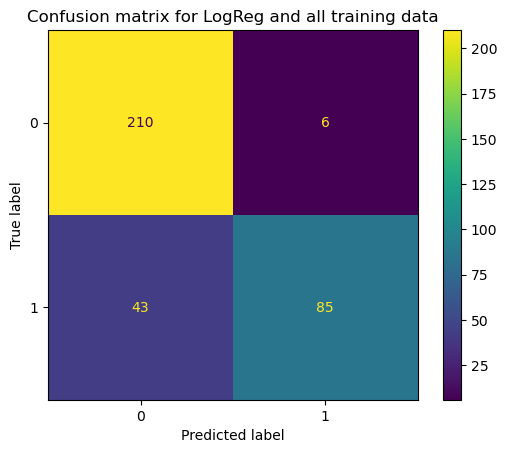

In [10]:
cm = confusion_matrix(y_agg, preds_log > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for LogReg and all training data");

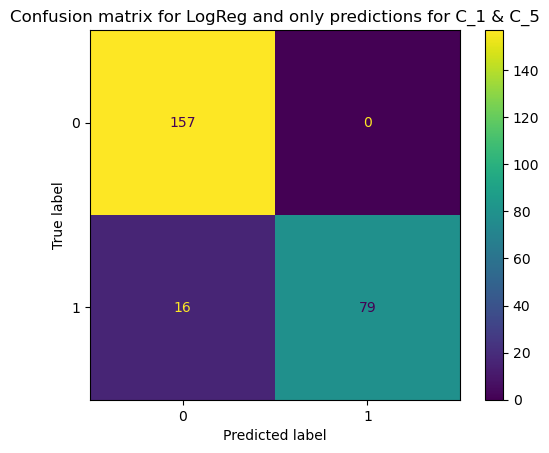

In [11]:
cm = confusion_matrix(y_agg[centers_agg != "C_2"], preds_log[centers_agg != "C_2"] > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for LogReg and only predictions for C_1 & C_5");

In [59]:
print("AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_log[centers_agg == "C_2"]))
print("AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_log[centers_agg == "C_1"]))
print("AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_log[centers_agg == "C_5"]))

AUC C_2:  0.6086286594761171
AUC C_1:  0.9915157074065581
AUC C_5:  0.9987212276214834


### Looking at predictions on test data for LogReg

In [12]:
preds_test_log = 0
# loop over the classifiers
for lr in lrs_log:
    temp = lr.predict_proba(X_test)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_test)
    preds_test_log += temp

# and take the average (ensembling technique)
preds_test_log = preds_test_log / len(lrs_log)

In [13]:
preds_test_log

array([0.36281314, 0.43611364, 0.11246348, 0.15196188, 0.25686479,
       0.55012678, 0.21980187, 0.13182645, 0.15240981, 0.27677939,
       0.31679578, 0.47769713, 0.24510159, 0.31643288, 0.17005777,
       0.46334199, 0.43105343, 0.34437435, 0.24018544, 0.34502344,
       0.15699355, 0.0914849 , 0.28476429, 0.3681663 , 0.33343485,
       0.19844309, 0.68696427, 0.29801671, 0.11267948, 0.36397226,
       0.16459175, 0.38684487, 0.38309683, 0.43592439, 0.4346609 ,
       0.2931529 , 0.12897563, 0.16527815, 0.10398579, 0.45241452,
       0.08546659, 0.25432325, 0.38084288, 0.43243093, 0.26033849,
       0.25088036, 0.20864713, 0.28268316, 0.31415273, 0.42270337,
       0.54854492, 0.15537266, 0.24507737, 0.54526763, 0.58926403,
       0.49655408, 0.20641271, 0.05494983, 0.43619774, 0.24406835,
       0.24443036, 0.23414964, 0.34489668, 0.54470318, 0.29202285,
       0.38489642, 0.49018977, 0.5261083 , 0.19452496, 0.5496236 ,
       0.35569364, 0.5495472 , 0.32843359, 0.35331309, 0.09029

## RF

In [14]:
estimator = trfs.get_tabular_estimator("RF")
lrs_rf = trfs.train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_unique,
    y_unique,
    patients_train,
    samples_train,
    centers_train,
    tile_avg=False,
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.630
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.615
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.589
----------------------------
5-fold cross-validated AUC averaged over 1 repeats: 0.611 (0.017)


In [15]:
preds_rf = 0
# loop over the classifiers
for lr in lrs_rf:
    temp = lr.predict_proba(X_train)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train)
    preds_rf += temp

# and take the average (ensembling technique)
preds_rf = preds_rf / len(lrs_rf)

In [16]:
preds_rf

array([0.12817, 0.4825 , 0.10154, 0.1204 , 0.46735, 0.09115, 0.41882,
       0.09869, 0.10407, 0.39487, 0.4193 , 0.1278 , 0.11442, 0.82802,
       0.82988, 0.09941, 0.29252, 0.82221, 0.78458, 0.79569, 0.77673,
       0.07474, 0.52149, 0.37061, 0.11968, 0.14168, 0.82714, 0.07409,
       0.4409 , 0.14352, 0.3688 , 0.80468, 0.07399, 0.09031, 0.80814,
       0.80035, 0.15728, 0.07977, 0.09372, 0.07955, 0.25889, 0.30745,
       0.1333 , 0.29229, 0.09287, 0.80405, 0.85506, 0.82132, 0.10871,
       0.0913 , 0.79544, 0.79907, 0.81478, 0.84142, 0.4622 , 0.12511,
       0.85385, 0.11822, 0.49684, 0.81279, 0.85641, 0.14451, 0.07974,
       0.28936, 0.83569, 0.10075, 0.11343, 0.82912, 0.10368, 0.29243,
       0.82335, 0.41424, 0.12348, 0.12001, 0.08466, 0.09536, 0.38163,
       0.11969, 0.10604, 0.46328, 0.81927, 0.05646, 0.42213, 0.35472,
       0.10244, 0.84436, 0.10895, 0.32477, 0.3431 , 0.81721, 0.84215,
       0.46286, 0.40938, 0.13699, 0.36075, 0.86599, 0.15749, 0.85577,
       0.12522, 0.31

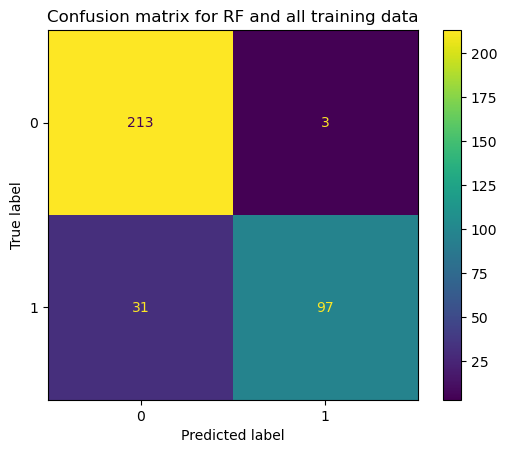

In [17]:
cm = confusion_matrix(y_agg, preds_rf > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for RF and all training data");

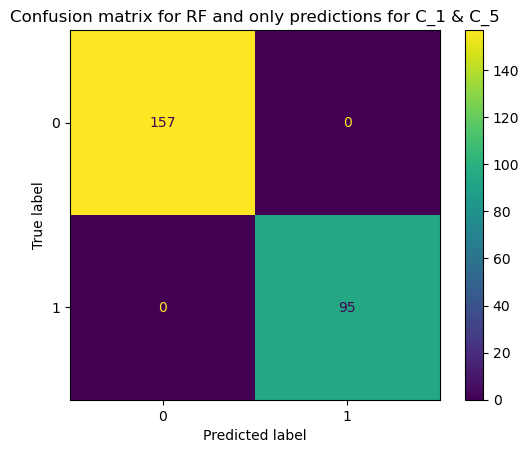

In [18]:
cm = confusion_matrix(y_agg[centers_agg != "C_2"], preds_rf[centers_agg != "C_2"] > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for RF and only predictions for C_1 & C_5");

Let's look more closely at the predictions of center 2...

In [19]:
y_agg[centers_agg == "C_2"]

array([1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1.])

In [20]:
preds_rf[centers_agg == "C_2"]

array([0.4825 , 0.46735, 0.41882, 0.39487, 0.4193 , 0.29252, 0.52149,
       0.37061, 0.4409 , 0.3688 , 0.25889, 0.30745, 0.29229, 0.4622 ,
       0.49684, 0.28936, 0.29243, 0.41424, 0.38163, 0.46328, 0.42213,
       0.35472, 0.32477, 0.3431 , 0.46286, 0.40938, 0.36075, 0.31193,
       0.44966, 0.41458, 0.37329, 0.37451, 0.44636, 0.29997, 0.46741,
       0.36588, 0.42031, 0.42877, 0.29206, 0.3546 , 0.41343, 0.4613 ,
       0.45074, 0.2772 , 0.3851 , 0.44683, 0.3032 , 0.39414, 0.33018,
       0.33483, 0.3259 , 0.27726, 0.31488, 0.24232, 0.38699, 0.41822,
       0.5179 , 0.33044, 0.39761, 0.34405, 0.43544, 0.52589, 0.27617,
       0.351  , 0.52563, 0.29546, 0.36775, 0.36457, 0.3226 , 0.38444,
       0.32933, 0.33539, 0.35891, 0.33283, 0.34022, 0.37176, 0.4019 ,
       0.4178 , 0.31493, 0.39635, 0.34982, 0.47146, 0.42097, 0.35351,
       0.367  , 0.33704, 0.27515, 0.31865, 0.31641, 0.35376, 0.58413,
       0.35262])

In [21]:
np.unique(samples_train)[centers_agg == "C_2"]

array(['ID_002.npy', 'ID_007.npy', 'ID_013.npy', 'ID_018.npy',
       'ID_019.npy', 'ID_026.npy', 'ID_037.npy', 'ID_039.npy',
       'ID_046.npy', 'ID_049.npy', 'ID_061.npy', 'ID_062.npy',
       'ID_064.npy', 'ID_080.npy', 'ID_084.npy', 'ID_090.npy',
       'ID_096.npy', 'ID_098.npy', 'ID_106.npy', 'ID_110.npy',
       'ID_113.npy', 'ID_114.npy', 'ID_118.npy', 'ID_120.npy',
       'ID_124.npy', 'ID_126.npy', 'ID_129.npy', 'ID_138.npy',
       'ID_139.npy', 'ID_150.npy', 'ID_151.npy', 'ID_153.npy',
       'ID_154.npy', 'ID_160.npy', 'ID_172.npy', 'ID_174.npy',
       'ID_176.npy', 'ID_180.npy', 'ID_184.npy', 'ID_190.npy',
       'ID_204.npy', 'ID_205.npy', 'ID_209.npy', 'ID_213.npy',
       'ID_220.npy', 'ID_221.npy', 'ID_226.npy', 'ID_227.npy',
       'ID_229.npy', 'ID_235.npy', 'ID_237.npy', 'ID_242.npy',
       'ID_245.npy', 'ID_249.npy', 'ID_258.npy', 'ID_264.npy',
       'ID_268.npy', 'ID_286.npy', 'ID_288.npy', 'ID_289.npy',
       'ID_301.npy', 'ID_307.npy', 'ID_309.npy', 'ID_32

### ROC & AUC for the different centers

In [22]:
print("AUC for C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_rf[centers_agg == "C_1"]))
print("AUC for C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_rf[centers_agg == "C_2"]))
print("AUC for C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_rf[centers_agg == "C_5"]))

AUC for C_1:  1.0
AUC for C_2:  0.5891114535182331
AUC for C_5:  1.0


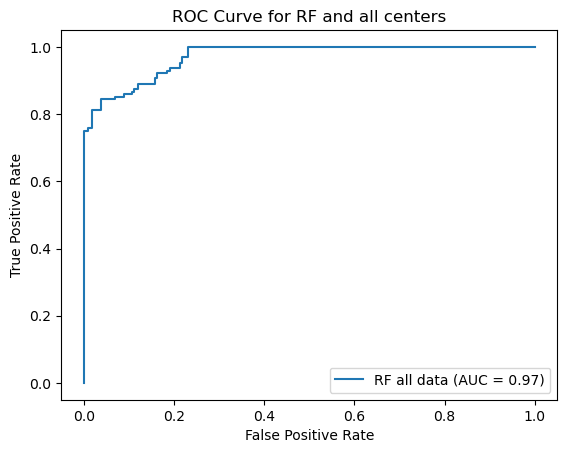

In [23]:
fpr, tpr, _ = roc_curve(y_agg, preds_rf)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='RF all data')
display.plot()
plt.title("ROC Curve for RF and all centers");

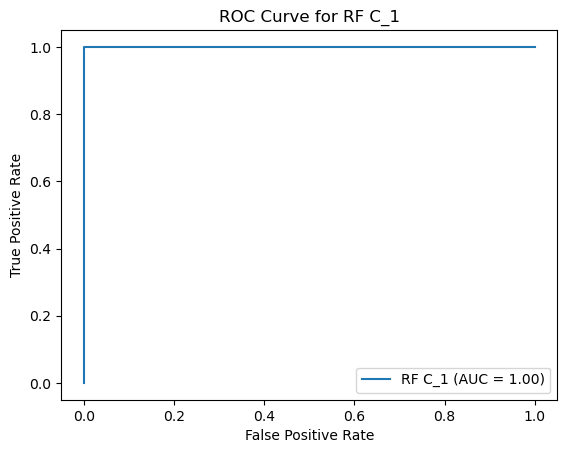

In [24]:
fpr, tpr, _ = roc_curve(y_agg[centers_agg == "C_1"], preds_rf[centers_agg == "C_1"])
roc_auc = auc(fpr, tpr)
display_c_1 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='RF C_1')
display_c_1.plot()
plt.title("ROC Curve for RF C_1");

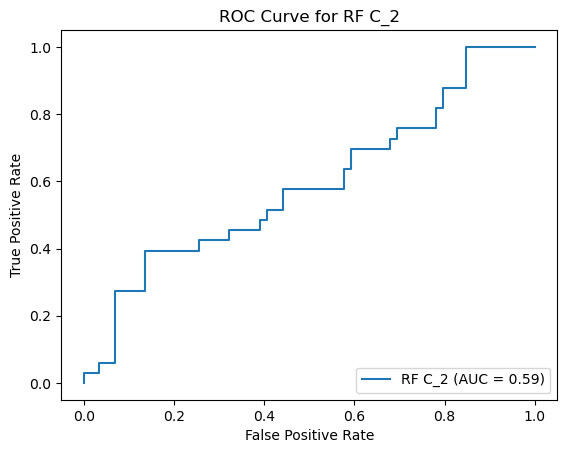

In [25]:
fpr, tpr, _ = roc_curve(y_agg[centers_agg == "C_2"], preds_rf[centers_agg == "C_2"])
roc_auc = auc(fpr, tpr)
display_c_2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='RF C_2')
display_c_2.plot()
plt.title("ROC Curve for RF C_2");

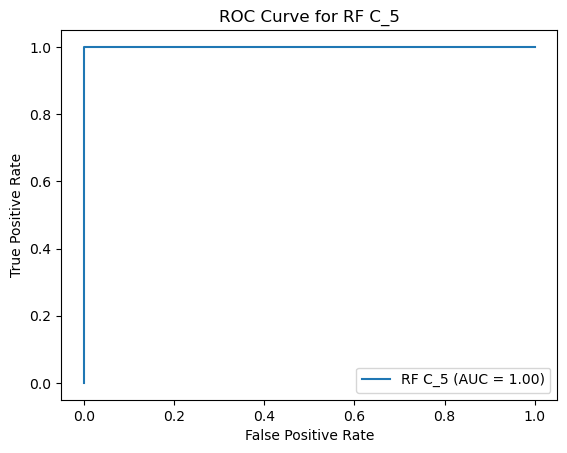

In [26]:
fpr, tpr, _ = roc_curve(y_agg[centers_agg == "C_5"], preds_rf[centers_agg == "C_5"])
roc_auc = auc(fpr, tpr)
display_c_5 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='RF C_5')
display_c_5.plot()
plt.title("ROC Curve for RF C_5");

### Taking a look at the values of the MoCo features

In [27]:
np.max(X_train[centers_train == "C_2"])

6.038034915924072

In [28]:
np.max(X_train[centers_train != "C_2"])

5.32080078125

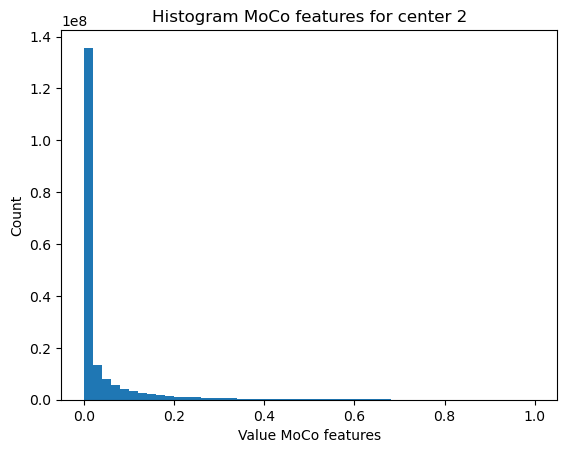

In [32]:
temp_hist = X_train[centers_train == "C_2"].flatten()
plt.hist(temp_hist[temp_hist < 1], bins=50)
plt.xlabel("Value MoCo features")
plt.ylabel("Count")
plt.title("Histogram MoCo features for center 2");

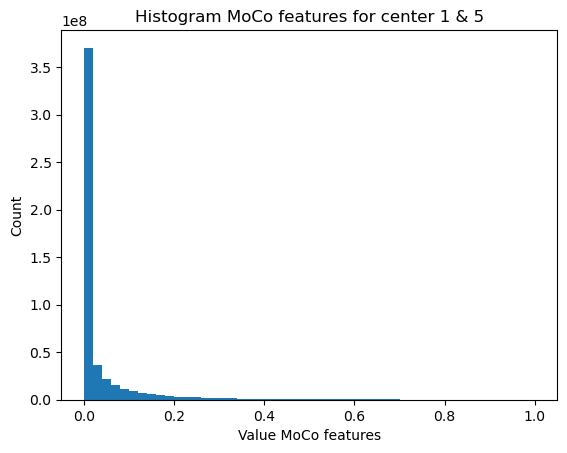

In [33]:
temp_hist = X_train[centers_train != "C_2"].flatten()
plt.hist(temp_hist[temp_hist < 1], bins=50)
plt.xlabel("Value MoCo features")
plt.ylabel("Count")
plt.title("Histogram MoCo features for center 1 & 5");

### Looking at the predictions on the test data

In [34]:
preds_test_rf = 0
# loop over the classifiers
for lr in lrs_rf:
    temp = lr.predict_proba(X_test)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_test)
    preds_test_rf += temp

# and take the average (ensembling technique)
preds_test_rf = preds_test_rf / len(lrs_rf)

In [35]:
preds_test_rf

array([0.43074, 0.47282, 0.44017, 0.41009, 0.37664, 0.47434, 0.29903,
       0.47199, 0.44839, 0.36761, 0.46239, 0.4601 , 0.44512, 0.39333,
       0.43924, 0.41763, 0.41064, 0.43472, 0.45379, 0.50185, 0.48239,
       0.42933, 0.39543, 0.44799, 0.54276, 0.47169, 0.53146, 0.41279,
       0.46938, 0.4813 , 0.41314, 0.45869, 0.43474, 0.44297, 0.41024,
       0.50293, 0.44074, 0.28769, 0.41607, 0.43343, 0.45059, 0.43544,
       0.38359, 0.41653, 0.34613, 0.33921, 0.41161, 0.48568, 0.36837,
       0.38406, 0.47485, 0.46514, 0.45264, 0.43579, 0.51876, 0.45222,
       0.48502, 0.46254, 0.44142, 0.37568, 0.48086, 0.43183, 0.37636,
       0.422  , 0.48266, 0.39349, 0.43305, 0.4826 , 0.44709, 0.45919,
       0.41211, 0.49127, 0.38528, 0.48782, 0.41393, 0.3747 , 0.42598,
       0.47199, 0.43454, 0.40353, 0.47221, 0.50515, 0.45113, 0.41358,
       0.43231, 0.42193, 0.46191, 0.44803, 0.51132, 0.46791, 0.39796,
       0.47631, 0.42542, 0.52798, 0.30549, 0.50055, 0.414  , 0.47022,
       0.4534 , 0.46

## Creating classifiers with training samples of only one center

In [7]:
estimator_C_2 = trfs.get_tabular_estimator("RF")
estimator_C_2.fit(X_train[centers_train == "C_2"], y_train[centers_train == "C_2"])

RandomForestClassifier(n_jobs=6)

In [8]:
preds_train_c_2 = estimator_C_2.predict_proba(X_train[centers_train == "C_2"])[:, 1]
preds_train_c_2 = trfs.pred_aggregation(preds_train_c_2, samples_train[centers_train == "C_2"])

preds_val_2_1 = estimator_C_2.predict_proba(X_train[centers_train == "C_1"])[:, 1]
preds_val_2_1 = trfs.pred_aggregation(preds_val_2_1, samples_train[centers_train == "C_1"])

preds_val_2_5 = estimator_C_2.predict_proba(X_train[centers_train == "C_5"])[:, 1]
preds_val_2_5 = trfs.pred_aggregation(preds_val_2_5, samples_train[centers_train == "C_5"])

In [9]:
print("Train AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_train_c_2))
print("Val AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_val_2_1))
print("Val AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_val_2_5))

Train AUC C_2:  1.0
Val AUC C_1:  0.596652144003669
Val AUC C_5:  0.6080562659846548


In [16]:
preds_test_c_2 = estimator_C_2.predict_proba(X_test)[:, 1]
preds_test_c_2 = trfs.pred_aggregation(preds_test_c_2, samples_test)
print(preds_test_c_2)

[0.40014 0.2931  0.2764  0.267   0.29458 0.40962 0.32165 0.18975 0.3186
 0.35263 0.30778 0.33012 0.33315 0.37455 0.27277 0.33903 0.34078 0.42274
 0.26377 0.2399  0.25797 0.17395 0.27669 0.42762 0.27659 0.2179  0.41078
 0.42751 0.14005 0.27955 0.28651 0.26743 0.26875 0.37811 0.35222 0.25477
 0.23152 0.40598 0.27319 0.33794 0.26487 0.28871 0.34249 0.2639  0.14096
 0.28743 0.31862 0.30445 0.34694 0.35279 0.36178 0.29889 0.33873 0.23613
 0.39989 0.34324 0.2675  0.24009 0.27531 0.25093 0.21973 0.2809  0.32505
 0.37107 0.24505 0.38754 0.31485 0.43897 0.20837 0.51398 0.33958 0.34532
 0.30513 0.26128 0.27157 0.26307 0.27845 0.30094 0.33531 0.25141 0.35768
 0.26919 0.30739 0.36053 0.26969 0.22714 0.26282 0.31449 0.30615 0.19344
 0.22151 0.27457 0.29034 0.14584 0.36137 0.22346 0.40165 0.2536  0.16529
 0.22044 0.25931 0.31622 0.32496 0.39675 0.21742 0.21508 0.247   0.34291
 0.28276 0.23982 0.27928 0.34424 0.34484 0.18772 0.35546 0.2657  0.24318
 0.31657 0.20499 0.30929 0.43416 0.27422 0.20689 0.3

In [18]:
# store_submission(preds_test_c_2, "RF_C2", Path("../storage"), Path("../submissions"))

In [10]:
estimator_C_1 = trfs.get_tabular_estimator("RF")
estimator_C_1.fit(X_train[centers_train == "C_1"], y_train[centers_train == "C_1"])

RandomForestClassifier(n_jobs=6)

In [11]:
preds_train_c_1 = estimator_C_1.predict_proba(X_train[centers_train == "C_1"])[:, 1]
preds_train_c_1 = trfs.pred_aggregation(preds_train_c_1, samples_train[centers_train == "C_1"])

preds_val_1_2 = estimator_C_1.predict_proba(X_train[centers_train == "C_2"])[:, 1]
preds_val_1_2 = trfs.pred_aggregation(preds_val_1_2, samples_train[centers_train == "C_2"])

preds_val_1_5 = estimator_C_1.predict_proba(X_train[centers_train == "C_5"])[:, 1]
preds_val_1_5 = trfs.pred_aggregation(preds_val_1_5, samples_train[centers_train == "C_5"])

In [12]:
print("Train AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_train_c_1))
print("Val AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_val_1_2))
print("Val AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_val_1_5))

Train AUC C_1:  1.0
Val AUC C_2:  0.5870570107858244
Val AUC C_5:  0.6465792838874681


In [21]:
preds_test_c_1 = estimator_C_1.predict_proba(X_test)[:, 1]
preds_test_c_1 = trfs.pred_aggregation(preds_test_c_1, samples_test)
print(preds_test_c_1)

[0.37116 0.54307 0.49667 0.43293 0.37395 0.48433 0.27059 0.50263 0.4636
 0.31576 0.42913 0.4451  0.46364 0.3728  0.48871 0.45262 0.39663 0.399
 0.4835  0.51013 0.52359 0.4784  0.33598 0.41182 0.56919 0.49938 0.54799
 0.40819 0.58513 0.48842 0.45207 0.46208 0.49152 0.42331 0.39763 0.51466
 0.52285 0.31823 0.43079 0.41434 0.50221 0.4562  0.39092 0.44846 0.31678
 0.35737 0.44715 0.49457 0.33684 0.35511 0.46722 0.48316 0.48768 0.38291
 0.48317 0.42098 0.49284 0.53491 0.46644 0.30438 0.58781 0.45762 0.29431
 0.42102 0.4964  0.41987 0.49429 0.4711  0.46836 0.42498 0.38851 0.55921
 0.39449 0.51046 0.46063 0.36288 0.37092 0.52953 0.37296 0.44117 0.4605
 0.56882 0.47512 0.38903 0.47039 0.43294 0.47658 0.40566 0.45029 0.57187
 0.42269 0.46222 0.4693  0.6257  0.43125 0.47584 0.41314 0.52177 0.49579
 0.57902 0.27867 0.48523 0.38141 0.43669 0.47427 0.51445 0.54622 0.44687
 0.39418 0.54475 0.25757 0.5058  0.46629 0.56894 0.41389 0.34351 0.52392
 0.29704 0.52062 0.48364 0.39841 0.35012 0.50729 0.4413

In [22]:
# store_submission(preds_test_c_1, "RF_C1", Path("../storage"), Path("../submissions"))

In [13]:
estimator_C_5 = trfs.get_tabular_estimator("RF")
estimator_C_5.fit(X_train[centers_train == "C_5"], y_train[centers_train == "C_5"])

RandomForestClassifier(n_jobs=6)

In [14]:
preds_train_c_5 = estimator_C_5.predict_proba(X_train[centers_train == "C_5"])[:, 1]
preds_train_c_5 = trfs.pred_aggregation(preds_train_c_5, samples_train[centers_train == "C_5"])

preds_val_5_1 = estimator_C_5.predict_proba(X_train[centers_train == "C_1"])[:, 1]
preds_val_5_1 = trfs.pred_aggregation(preds_val_5_1, samples_train[centers_train == "C_1"])

preds_val_5_2 = estimator_C_5.predict_proba(X_train[centers_train == "C_2"])[:, 1]
preds_val_5_2 = trfs.pred_aggregation(preds_val_5_2, samples_train[centers_train == "C_2"])

In [15]:
print("Train AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_train_c_5))
print("Val AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_val_5_1))
print("Val AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_val_5_2))

Train AUC C_5:  1.0
Val AUC C_1:  0.6186654437055722
Val AUC C_2:  0.5824345146379045


In [23]:
preds_test_c_5 = estimator_C_5.predict_proba(X_test)[:, 1]
preds_test_c_5 = trfs.pred_aggregation(preds_test_c_5, samples_test)
print(preds_test_c_5)

[0.48508 0.44217 0.42265 0.40488 0.38927 0.46879 0.35606 0.45724 0.45626
 0.4362  0.4626  0.45786 0.41908 0.41914 0.4197  0.39869 0.41055 0.50409
 0.43012 0.50074 0.46517 0.42013 0.45973 0.47799 0.50506 0.46069 0.50391
 0.41361 0.41405 0.47315 0.38988 0.45485 0.41104 0.44237 0.41759 0.48769
 0.41363 0.30415 0.4377  0.44396 0.44948 0.43851 0.38304 0.39866 0.39787
 0.34025 0.39832 0.47835 0.42307 0.41961 0.45806 0.44371 0.44712 0.44404
 0.50126 0.47281 0.47123 0.43057 0.42057 0.4322  0.45415 0.42705 0.46761
 0.43098 0.49015 0.39552 0.39833 0.48474 0.44515 0.50774 0.42657 0.44548
 0.38596 0.48281 0.41384 0.38411 0.44706 0.42492 0.47303 0.37742 0.455
 0.46879 0.43835 0.42248 0.41233 0.43384 0.47521 0.46388 0.52772 0.44137
 0.41643 0.48688 0.41452 0.47565 0.2199  0.5044  0.40722 0.44969 0.43434
 0.42648 0.22287 0.40593 0.42783 0.50362 0.44231 0.41862 0.45497 0.48437
 0.37088 0.4511  0.35684 0.50842 0.46369 0.449   0.41889 0.40768 0.41924
 0.41023 0.44932 0.43676 0.35163 0.35671 0.4384  0.46

In [24]:
# store_submission(preds_test_c_5, "RF_C5", Path("../storage"), Path("../submissions"))

### Submission trained on all data without cv split

In [7]:
estimator_all = trfs.get_tabular_estimator("LogReg")
estimator_all.fit(X_train, y_train)

/Users/mariastoelben/opt/anaconda3/envs/PythonforDataScience/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [8]:
preds_all_c_5 = estimator_all.predict_proba(X_train[centers_train == "C_5"])[:, 1]
preds_all_c_5 = trfs.pred_aggregation(preds_all_c_5, samples_train[centers_train == "C_5"])

preds_all_c_1 = estimator_all.predict_proba(X_train[centers_train == "C_1"])[:, 1]
preds_all_c_1 = trfs.pred_aggregation(preds_all_c_1, samples_train[centers_train == "C_1"])

preds_all_c_2 = estimator_all.predict_proba(X_train[centers_train == "C_2"])[:, 1]
preds_all_c_2 = trfs.pred_aggregation(preds_all_c_2, samples_train[centers_train == "C_2"])

In [9]:
print("Train AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_all_c_5))
print("Train AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_all_c_1))
print("Train AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_all_c_2))

Train AUC C_5:  0.993925831202046
Train AUC C_1:  0.981196973171291
Train AUC C_2:  0.9979455572675912


In [10]:
preds_test_all = estimator_all.predict_proba(X_test)[:, 1]
preds_test_all = trfs.pred_aggregation(preds_test_all, samples_test)
print(preds_test_all)

[0.41162507 0.39217949 0.0494676  0.1583913  0.33812802 0.39318697
 0.2401938  0.08023457 0.02572855 0.32200913 0.17758555 0.38786024
 0.29722805 0.3109863  0.11002925 0.35737968 0.37974162 0.40547893
 0.1675646  0.13144658 0.044274   0.04733426 0.21544283 0.34344511
 0.08566474 0.0629227  0.61925764 0.32011019 0.03720549 0.13255626
 0.27297061 0.24635461 0.32258189 0.41674593 0.38258813 0.11657508
 0.05169319 0.22713048 0.08887227 0.43498922 0.03234536 0.17120685
 0.3450385  0.40479423 0.18187653 0.28944252 0.0652442  0.1165394
 0.3336943  0.38887681 0.43487334 0.10931876 0.09179956 0.44158741
 0.50174921 0.48854248 0.07151326 0.02130446 0.30255395 0.22720522
 0.11692848 0.19670536 0.29402932 0.4474106  0.04066269 0.36901813
 0.52558073 0.46736217 0.05305    0.57122733 0.32250234 0.49078079
 0.45271892 0.08191722 0.05458122 0.31612947 0.37573063 0.25592666
 0.35073363 0.30494709 0.44500241 0.1488589  0.14353756 0.46255563
 0.2401554  0.01754675 0.01675288 0.31657013 0.49098009 0.09150

In [11]:
# store_submission(preds_test_all, "Log_Reg_all", Path("../storage"), Path("../submissions"))

Same for the random forest...

In [18]:
estimator_all = trfs.get_tabular_estimator("RF")
estimator_all.fit(X_train, y_train)

RandomForestClassifier(n_jobs=6)

In [19]:
preds_all_c_5 = estimator_all.predict_proba(X_train[centers_train == "C_5"])[:, 1]
preds_all_c_5 = trfs.pred_aggregation(preds_all_c_5, samples_train[centers_train == "C_5"])

preds_all_c_1 = estimator_all.predict_proba(X_train[centers_train == "C_1"])[:, 1]
preds_all_c_1 = trfs.pred_aggregation(preds_all_c_1, samples_train[centers_train == "C_1"])

preds_all_c_2 = estimator_all.predict_proba(X_train[centers_train == "C_2"])[:, 1]
preds_all_c_2 = trfs.pred_aggregation(preds_all_c_2, samples_train[centers_train == "C_2"])

In [20]:
print("Train AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_all_c_5))
print("Train AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_all_c_1))
print("Train AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_all_c_2))

Train AUC C_5:  1.0
Train AUC C_1:  1.0
Train AUC C_2:  1.0


In [21]:
preds_test_all = estimator_all.predict_proba(X_test)[:, 1]
preds_test_all = trfs.pred_aggregation(preds_test_all, samples_test)
print(preds_test_all)

[0.42816 0.43297 0.40861 0.36706 0.34956 0.47364 0.29958 0.41146 0.41928
 0.36713 0.4113  0.40757 0.41909 0.40032 0.40724 0.37445 0.38473 0.43315
 0.4086  0.44847 0.44359 0.37825 0.33545 0.447   0.4981  0.41232 0.50552
 0.41761 0.41226 0.43738 0.36751 0.41589 0.39587 0.42824 0.39935 0.45289
 0.39451 0.3243  0.37804 0.41235 0.41153 0.3977  0.37076 0.37315 0.27411
 0.31946 0.38472 0.44982 0.3597  0.38201 0.43976 0.43501 0.42548 0.40577
 0.47782 0.43279 0.43711 0.41635 0.39042 0.34296 0.43726 0.38846 0.3723
 0.4315  0.44711 0.39171 0.4068  0.4792  0.38381 0.5008  0.38883 0.47455
 0.36671 0.44882 0.38396 0.357   0.38194 0.45337 0.42402 0.36003 0.4399
 0.45984 0.42316 0.41915 0.38551 0.37158 0.41732 0.40341 0.47444 0.41072
 0.35582 0.44643 0.39335 0.43756 0.31135 0.43071 0.4108  0.4229  0.39772
 0.41089 0.25916 0.40672 0.39357 0.48651 0.38766 0.36745 0.43779 0.4447
 0.34381 0.43832 0.27978 0.47383 0.44986 0.43102 0.39939 0.35729 0.39797
 0.35425 0.40839 0.40523 0.39445 0.31627 0.40204 0.431

In [22]:
# store_submission(preds_test_all, "RF_all", Path("../storage"), Path("../submissions"))

## Testing different prediction aggregation methods for predictions

First the upper 25% mean...

In [39]:
preds_25 = 0
# loop over the classifiers
for lr in lrs_rf:
    temp = lr.predict_proba(X_train)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train, "mean_25")
    preds_25 += temp

# and take the average (ensembling technique)
preds_25 = preds_25 / len(lrs_rf)

In [40]:
print("AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_25[centers_agg == "C_2"]))
print("AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_25[centers_agg == "C_1"]))
print("AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_25[centers_agg == "C_5"]))

AUC C_2:  0.5808936825885979
AUC C_1:  1.0
AUC C_5:  1.0


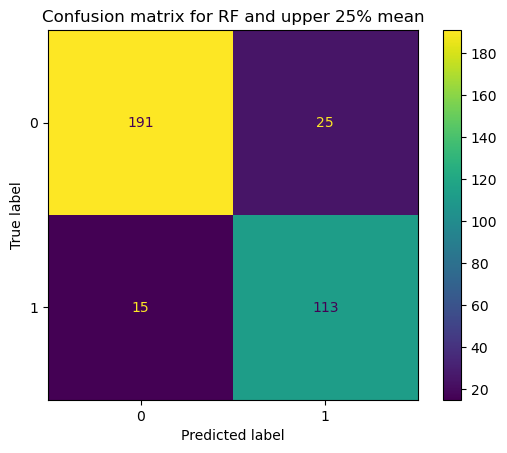

In [41]:
cm = confusion_matrix(y_agg, preds_25 > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for RF and upper 25% mean");

Next, the upper 50% mean...

In [42]:
preds_50 = 0
# loop over the classifiers
for lr in lrs_rf:
    temp = lr.predict_proba(X_train)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train, "mean_50")
    preds_50 += temp

# and take the average (ensembling technique)
preds_50 = preds_50 / len(lrs_rf)

In [43]:
print("AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_50[centers_agg == "C_2"]))
print("AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_50[centers_agg == "C_1"]))
print("AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_50[centers_agg == "C_5"]))

AUC C_2:  0.5814072932717
AUC C_1:  1.0
AUC C_5:  1.0


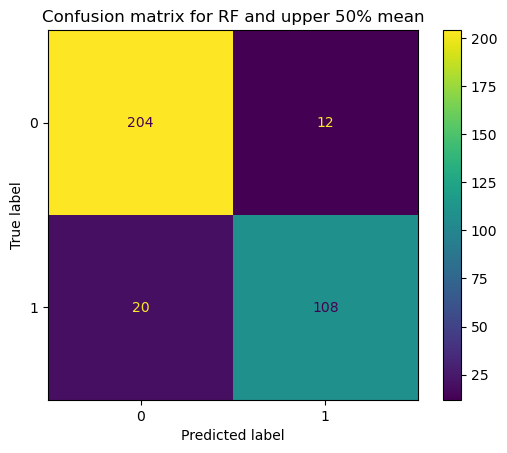

In [44]:
cm = confusion_matrix(y_agg, preds_50 > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for RF and upper 50% mean");

Finally, the upper 75% mean...

In [45]:
preds_75 = 0
# loop over the classifiers
for lr in lrs_rf:
    temp = lr.predict_proba(X_train)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train, "mean_50")
    preds_75 += temp

# and take the average (ensembling technique)
preds_75 = preds_75 / len(lrs_rf)

In [46]:
print("AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_75[centers_agg == "C_2"]))
print("AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_75[centers_agg == "C_1"]))
print("AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_75[centers_agg == "C_5"]))

AUC C_2:  0.5814072932717
AUC C_1:  1.0
AUC C_5:  1.0


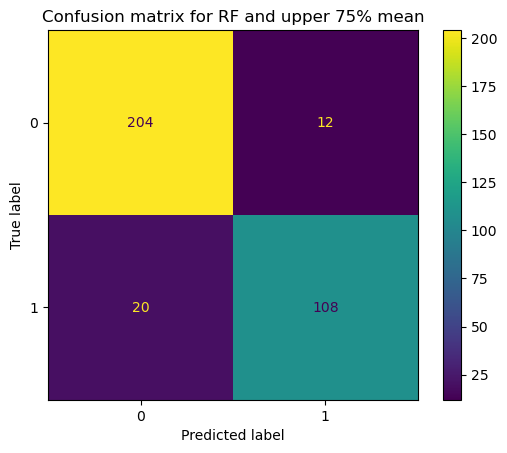

In [47]:
cm = confusion_matrix(y_agg, preds_75 > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for RF and upper 75% mean");

## PCA for LogReg and RF

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

In [27]:
pca = PCA(n_components=50)
X_PCA = pca.fit_transform(X_scaled)

In [28]:
print(pca.explained_variance_ratio_)

[0.04742969 0.03268537 0.02661569 0.02513273 0.02095062 0.01942504
 0.01625628 0.01421645 0.01338424 0.01324946 0.01185965 0.01139824
 0.01017145 0.00987684 0.00880216 0.00853812 0.00796318 0.00789978
 0.00733101 0.00706129 0.00659091 0.00651307 0.00642211 0.00621357
 0.00599326 0.00583518 0.00568132 0.00526511 0.00517486 0.00514889
 0.00497571 0.00489028 0.00476199 0.00461    0.00443876 0.00439012
 0.00426102 0.00419035 0.00411749 0.00396701 0.00379881 0.00375194
 0.00368034 0.00362177 0.00347376 0.00342328 0.00336979 0.00321829
 0.00314987 0.00314295]


In [51]:
estimator = trfs.get_tabular_estimator("RF")
lrs_rf_PCA = trfs.train_mocov_features(
    estimator,
    X_PCA,
    y_train,
    patients_unique,
    y_unique,
    patients_train,
    samples_train,
    centers_train,
    tile_avg=False,
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.642
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.638
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.609
----------------------------
5-fold cross-validated AUC averaged over 1 repeats: 0.630 (0.015)


In [52]:
preds_rf_PCA = 0
# loop over the classifiers
for lr in lrs_rf_PCA:
    temp = lr.predict_proba(X_PCA)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train)
    preds_rf_PCA += temp

# and take the average (ensembling technique)
preds_rf_PCA = preds_rf_PCA / len(lrs_rf_PCA)

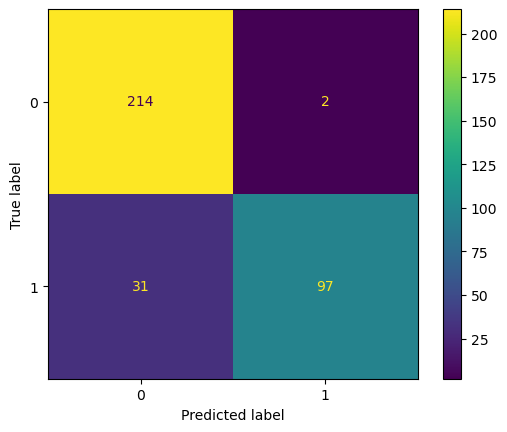

In [53]:
cm = confusion_matrix(y_agg, preds_rf_PCA > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [57]:
print("AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_rf_PCA[centers_agg == "C_2"]))
print("AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_rf_PCA[centers_agg == "C_1"]))
print("AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_rf_PCA[centers_agg == "C_5"]))

AUC C_2:  0.6088854648176683
AUC C_1:  1.0
AUC C_5:  1.0


### PCA for LogReg

In [29]:
estimator = trfs.get_tabular_estimator("LogReg")
lrs_lr_PCA = trfs.train_mocov_features(
    estimator,
    X_PCA,
    y_train,
    patients_unique,
    y_unique,
    patients_train,
    samples_train,
    centers_train,
    tile_avg=False,
)

AUC on split 0 validation center C_1: Train - 0.823, Val - 0.626
AUC on split 0 validation center C_5: Train - 0.805, Val - 0.641
AUC on split 0 validation center C_2: Train - 0.808, Val - 0.596
----------------------------
5-fold cross-validated AUC averaged over 1 repeats: 0.621 (0.019)


In [30]:
preds_log_PCA = 0
# loop over the classifiers
for lr in lrs_lr_PCA:
    temp = lr.predict_proba(X_PCA)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train)
    preds_log_PCA += temp

# and take the average (ensembling technique)
preds_log_PCA = preds_log_PCA / len(lrs_lr_PCA)

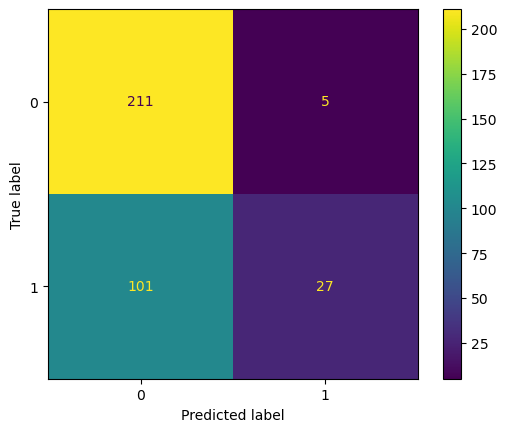

In [31]:
cm = confusion_matrix(y_agg, preds_log_PCA > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [32]:
print("AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_log_PCA[centers_agg == "C_2"]))
print("AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_log_PCA[centers_agg == "C_1"]))
print("AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_log_PCA[centers_agg == "C_5"]))

AUC C_2:  0.5963020030816641
AUC C_1:  0.7959183673469387
AUC C_5:  0.8366368286445013


In [33]:
preds_test_PCA = 0
X_PCA_test = pca.transform(scaler.transform(X_test))
# loop over the classifiers
for lr in lrs_lr_PCA:
    temp = lr.predict_proba(X_PCA_test)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_test)
    preds_test_PCA += temp

# and take the average (ensembling technique)
preds_test_PCA = preds_test_PCA / len(lrs_lr_PCA)

In [35]:
# store_submission(preds_test_PCA, "LogReg_PCA50", Path("../storage"), Path("../submissions"))